## Modified ResNet

We present the modified ResNet model with number of parameter unders 5 milions parameter which can achieve 94% accuracy in CIFAR10 testing dataset, and  82.6 % on custom data (NoLabel dataset).

### Necessary libraries

In [ ]:
!pip install "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts"
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
import torchvision.datasets as datasets
import torch.utils.data as data
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
# from torchmetrics.functional import accuracy
from torchmetrics import Accuracy
import torchsummary

### Loading and visualizing the dataset

We obtained the dataset from the `CIFAR10DataModule` within the `pl_bolts.datamodules` module of PyTorch Lightning Bolts. This module conveniently includes pre-split training, testing, and validation datasets. Additionally, it provides a `transform` function which we utilized to augment the data, enhancing the diversity of the training samples and improving the generalization ability of our model.

Here we defined a sequence of transformations to be applied to the training and Testing datasets. It includes:
RandomCrop: Randomly crops the input image to the specified size (32x32) with padding.
RandomHorizontalFlip: Randomly flips the input image horizontally with a probability of 0.5.
ToTensor: Converts the input image to a PyTorch tensor.
cifar10_normalization(): Applies normalization process, including scaling the pixel values to a specific range between 0 and 1 and standardizing them using the mean and standard deviation of the CIFAR-10 dataset.



We also can visualize random images from dataset in the figure below.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 7


100%|██████████| 170498071/170498071 [00:03<00:00, 43324048.68it/s]


Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working/
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


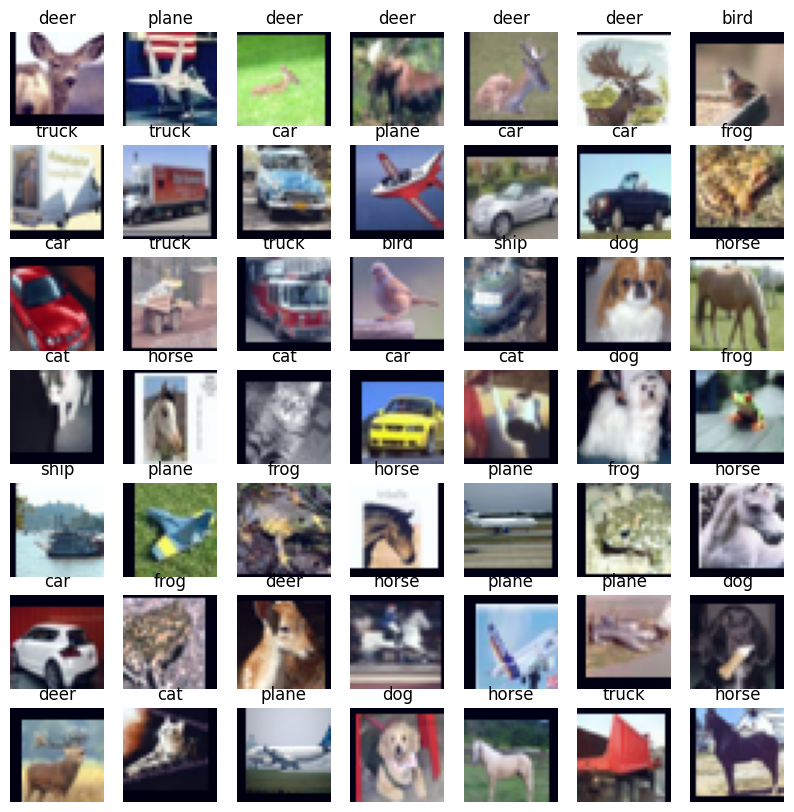

In [ ]:
seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", "/")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)


import matplotlib.pyplot as plt


def plot_images(images, labels, classes, normalize=False):
    """Plot a grid of subplots with the given images and their corresponding labels."""
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        img = images[i]
        if normalize:
            img = img.clone()
            img_min = img.min()
            img_max = img.max()
            img.clamp_(min=img_min, max=img_max)
            img.add_(-img_min).div_(img_max - img_min + 1e-5)

        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()

def display_random_images(data_module, num_images=50):
    """Fetches images from the dataset and displays them."""
    data_module.prepare_data()
    data_module.setup()

    train_loader = data_module.train_dataloader()
    images, labels = next(iter(train_loader))

    # Randomly select `num_images` images
    indices = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plot_images(selected_images, selected_labels, classes, normalize=True)

display_random_images(cifar10_dm)

### Defining the Model

We defind the Basic Blocks which is the construction of Resnet via Pytorch. Each Basic Block consists of several convolutional layers coupled with batch normalization and ReLU activations.The most distinguish feature "shortcut connections", which address vanishing gradient.
 In our work, the basic block contains:
1. Two Convolutional Layers:
The first convolutional layer applies a set filters to the input feature map and the second convolutional layer further processes the output of the first, applying an additional set of filters. Both layers typically use a 3x3 kernel and include a bias term.

2. Batch Normalization Layers:
Following each convolutional layer, a batch normalization layer is used. This layer normalizes the output of the convolution by adjusting and scaling the activations.
3. ReLU Activations:
After each batch normalization layer, a ReLU (Rectified Linear Unit) activation function is applied. The ReLU function introduces non-linearity to the processing.
4. Shortcut Connections:
This connection directly forwards the input x to the end of the block.

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

We define the ResNet model contains numbes of layers, each containing multiple BasicBlock which mentioned in previous section. To be specific, it contains:
1. Initial Convolutional Layer: a convolution layer with 64 filters 5x5 dimension followed by a batch normalization layer.
2. Stacked BasicBlock Layers: four layers, each made up of multiple 'BasicBlock'.
3. Final linear layer: a fully connected layer to get classification result for the 10 classes.


In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5,
                               stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         out =
        return out

We present our model by reducing the number of blocks  from the last 3 layers presented by RESNET18 Structure to get the number of parameters under 5M.So our  Resnet model structure [2,1,1,1] representing number of blocks at each layer.


In [ ]:
def Our_ResNet():
    return ResNet(BasicBlock, [2, 1, 1, 1])

We calculate the total number of parameters in the model via torchsummary.

In [ ]:
!pip install torchsummary
import torchsummary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Our_ResNet()
model = model.to(device)

torchsummary.summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           4,864
       BatchNorm2d-2           [-1, 64, 30, 30]             128
            Conv2d-3           [-1, 64, 30, 30]          36,928
       BatchNorm2d-4           [-1, 64, 30, 30]             128
            Conv2d-5           [-1, 64, 30, 30]          36,928
       BatchNorm2d-6           [-1, 64, 30, 30]             128
        BasicBlock-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]          36,928
       BatchNorm2d-9           [-1, 64, 30, 30]             128
           Conv2d-10           [-1, 64, 30, 30]          36,928
      BatchNorm2d-11           [-1, 64, 30, 30]             128
       BasicBlock-12           [-1, 64, 30, 30]               0
           Conv2d-13          [-1, 128, 15, 15]          73,856
      BatchNorm2d-14          [-1, 128,

The initial value of the weights and biases is set by the following function.

In [ ]:
def initialize_parameters(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model.apply(initialize_parameters)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

### Training the Model.
We intergrate our Model with [PyTorch Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) which can simplifies the training workflow and is designed for a multiclass classification task. It contains:
1. Accuracy Metric: Setup for multiclass accuracy evaluation.
2. Model Initialization: constructs the ResNet model and initializes its parameters.
3. LightningModule Configuration: Defines training, validation, testing steps, and the optimization setup.

Our optimazing parameters:
1. Optimizer : we chose Stochastic Gradient Descent (SGD) with momentum. SGD is a widely used optimization algorithm as itt updates the model parameters in the direction of the negative gradient of the loss function with respect to the parameters. The momentum term in SGD helps speed up convergence by taking information from past gradients. This helps smooth out fluctuations in the optimization process, leading to more stable and efficient training
2. OneCycleLR Scheduler: The OneCycleLR scheduler is chosen to dynamically adjust the learning rate which leads to improving convergence and preventing overfitting.



In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=10).to(device='cuda')
def create_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Our_ResNet()
    model = model.to(device)
    model.apply(initialize_parameters)

    return model

class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log("train_loss", loss)
        self.log("train_acc", acc)

        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


We utilize the `LitResnet` class, to train our model with CIFAR10 dataset, including:
1. Learning rate 0.05
2. Number epochs of training 200

Through this process, we save the train and validation accuracy in log file and save the final model at the final.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = LitResnet(lr=0.05)

trainer = Trainer(
    max_epochs=200,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir=r"/logs"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
# trainer.test(model, datamodule=cifar10_dm)
sum(p.numel() for p in model.parameters() if p.requires_grad)
torch.save(model.model.state_dict(), '/200_model.pth')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 5.0 M 
---------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.933    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
torch.save( model.state_dict(), r'/200_model.pth' )

The training and validation accuracy can be plot based on the logfile.


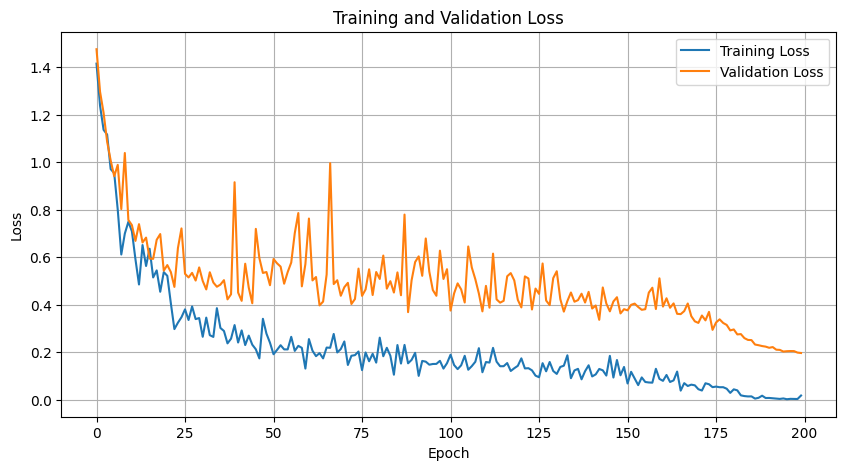

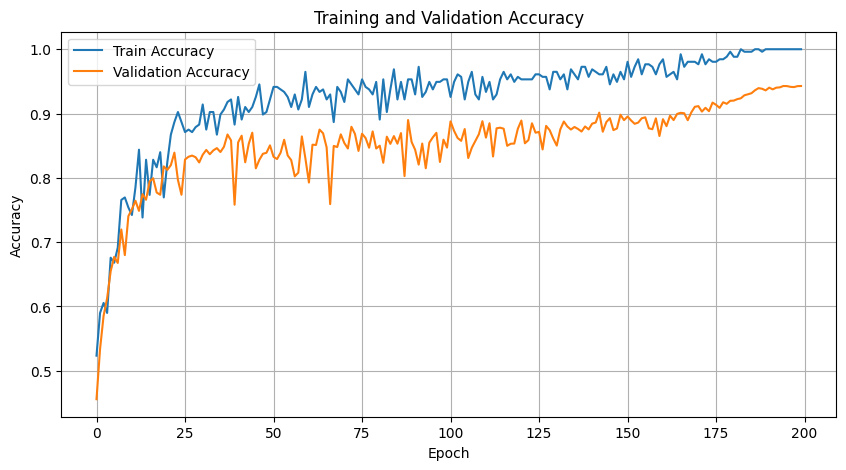

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
Traning_accuracy_final =  0
validation_accuracy_final = 0
def plot_training_metrics(csv_file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    # Remove rows with empty values in the specified columns
    val_acc_series = df['val_acc'].values
    val_acc_array = val_acc_series[~np.isnan(val_acc_series)]
    train_acc_series = df['train_acc'].values
    train_acc_array = train_acc_series[~np.isnan(train_acc_series)]
    val_loss_series = df['val_loss'].values
    val_loss_array = val_loss_series[~np.isnan(val_loss_series)]
    epoch_series = df['epoch'].values
    indices_train_not_nan = np.where(df['train_acc'].notna())[0]
    indices_epoch_not_nan = np.where(df['epoch'].notna())[0]

    common_indices = list(set(indices_train_not_nan).intersection(indices_epoch_not_nan))
    answer =[0]*len(val_loss_array)

    for epoch_i in range(len(val_loss_array)):
        for id, real_id in enumerate(common_indices):
            if(epoch_series[real_id] == epoch_i):
                answer[epoch_i] = real_id
    train_loss_series = df['train_loss'].values
    train_loss_array = train_loss_series[~np.isnan(train_loss_series)]
    selected_train_acc_array = train_acc_series[answer]
    selected_train_loss_array = train_loss_series[answer]
    epoch = list(range(len(selected_train_loss_array)))
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(epoch, selected_train_loss_array, label='Training Loss')
    plt.plot(epoch, val_loss_array , label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    epoch = list(range(len(val_acc_array)))
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epoch, selected_train_acc_array, label='Train Accuracy')
    plt.plot(epoch, val_acc_array, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    traning_accuracy_final =  selected_train_acc_array[-1]
    validation_accuracy_final = val_acc_array[-1]
    return traning_accuracy_final , validation_accuracy_final
traning_accuracy_final, validation_accuracy_fina = plot_training_metrics(r"/logs/lightning_logs/version_0/metrics.csv")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We got the accuracy of 0.94 with test dataset from CIFAR-10 Dataset.

In [ ]:
trainer.test(model, datamodule=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.940500020980835     │
│         test_loss         │    0.22141557931900024    │
└───────────────────────────┴───────────────────────────┘

### Evaluating the Model with the unlabled dataset.

We reuse the model saved from the previous one to predict the label of the custom dataset. Compared with the result in Kaggle, we achieved around 83% of accuracy.

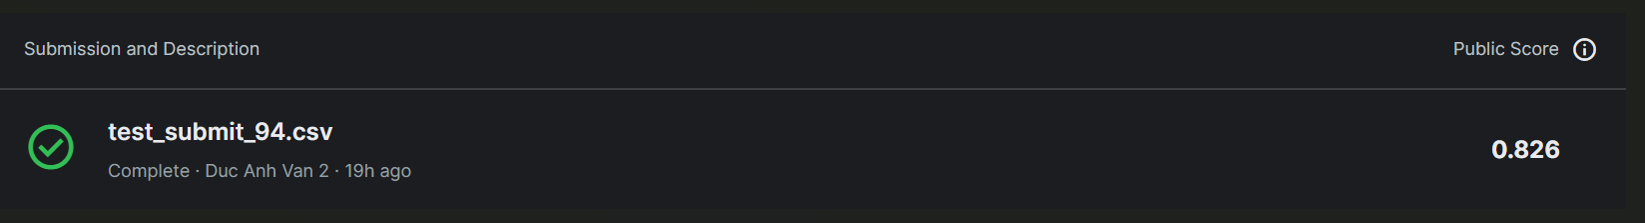

In [ ]:
from torchvision.transforms import v2
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

model.load_state_dict(torch.load('/200_model.pth'))

test_for_submit = unpickle('/cifar_test_nolabels.pkl')
data_for_submit = test_for_submit[b'data']/255.0
data_for_submit_tensor = torch.tensor(data_for_submit.reshape(-1, 3, 32, 32)).float()  # Adjusting for channel position

test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        cifar10_normalization(),
    ]
)
data_for_submit_tensor = test_transforms(data_for_submit_tensor)
data_for_submit_tensor = data_for_submit_tensor.to(device)

model.model.eval() # evaluate
model.model.to(device)
y_predict = []
for i in range(0, 10000, 200):
    logits = model.model(data_for_submit_tensor[i:i+200])
    preds = torch.argmax(logits, dim=1).cpu().numpy()
#     print(preds)
    y_predict.append(preds)


my_answer = np.array(y_predict).flatten()

id = list(range(10000))
value = my_answer

# create a dictionary with the three lists
dict = {'ID': id, 'labels': value}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('/test_submit_94.csv', index=False)
df[['labels']].value_counts()
# df.


labels
9         1089
5         1082
3         1072
8         1054
7         1031
4          960
6          946
0          931
1          923
2          912
Name: count, dtype: int64

Here's an image of how the csv file looks like

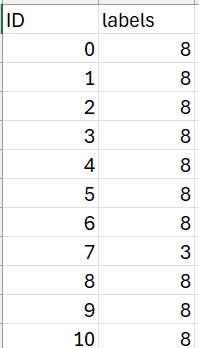

# Summary of our ResNet Model Results                                             







In [ ]:

print(f"1. Training Data Accuracy: {0.99:.2f} \n"
      f"2. Validation Data Accuracy: {0.94:.2f}\n"
      f"3. No-Label Data Accuracy: {0.828:.2f}\n"
      f"4. Number of Parameters for our Model: {4_983_306:,}")


1. Training Data Accuracy: 0.99 
2. Validation Data Accuracy: 0.94
3. No-Label Data Accuracy: 0.83
4. Number of Parameters for our Model: 4,983,306


Lastly, we plot some images from the unlabeled dataset and their predicted class to visually inspect our model's performance.

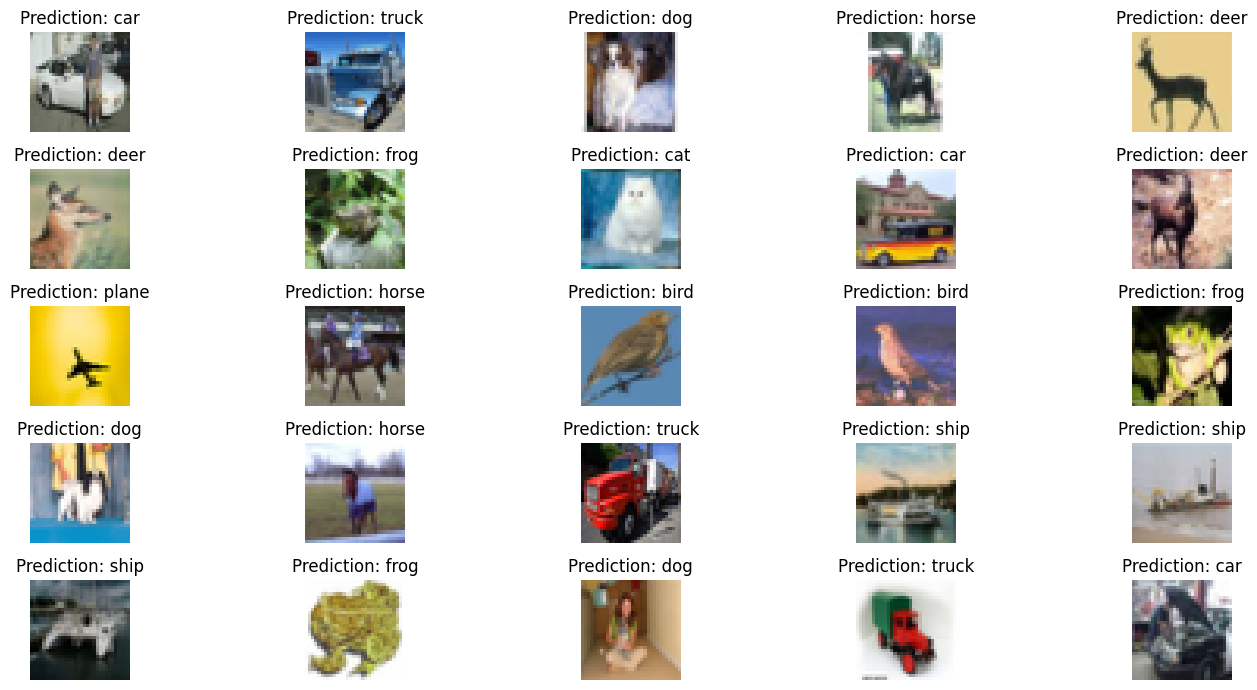

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

image_data = unpickle('/cifar_test_nolabels.pkl')

df = pd.read_csv('/test_submit_94.csv')
image_ids = df['ID']
prediction_labels = df['labels']

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_classes = [classes[label] for label in prediction_labels]

N = 25
random_indices = np.random.choice(len(image_data[b'data']), N, replace=False)

fig, axes = plt.subplots(N//5, 5, figsize=(15, 7))
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    reshaped_image = image_data[b'data'][idx].reshape(3, 32, 32)
    ax.imshow(np.transpose(reshaped_image, (1, 2, 0)))
    ax.set_title(f"Prediction: {predicted_classes[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()
